In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as pycaps_radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909', '033116'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis
casedate = '033116'

# Import the file containing the dictionaries needed to gather the radar, disdrometer, and model data.
sys.path.append('/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/configs/2016_IOP3')

from PIPSsim_1km_dicts import *

In [8]:
# Read in the PIPS data for the first probe for testing
dis_dict = init_dis_dict[casedate]
dirname = dis_dict['dis_dir']
filename = dis_dict['disfilenames'][0]
filepath = os.path.join(dirname, filename)
print("Reading file: {}".format(filepath))
conv_df, parsivel_df, vd_matrix_da = pipsio.read_PIPS(filepath)

Reading file: /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/PIPS/2016/IOP3/PIPS_1A_IOP_3_D1.txt
GPS time: Thu Mar 31 22:12:03 2016, Logger time: Thu Mar 31 22:12:00 2016
GPS Offset: 0:00:03


In [10]:
# Read sweep files
radar_name = init_radar_dict[casedate]['radname']
radar_dir = init_radar_dict[casedate]['radardir']
starttime = init_radar_dict[casedate]['radstarttimestamp']
stoptime = init_radar_dict[casedate]['radstoptimestamp']
field_names = init_radar_dict[casedate]['fieldnames']
el_req = init_radar_dict[casedate]['el_req']

radar_dict = radar.read_sweeps(radar_name, radar_dir, starttime, stoptime, field_names=field_names, 
                               el_req=el_req, compute_kdp=False)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_232540.010_to_20160331_232942.705_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 23:25:40 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_224349.896_to_20160331_224806.980_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:43:49 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_233553.663_to_20160331_234010.581_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:35:53 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_223849.284_to_20160331_224244.646_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 22:38:49 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_222848.491_to_20160331_223242.346_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:28:48 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_225928.203_to_20160331_230336.351_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:59:28 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_230443.929_to_20160331_230904.369_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.8129883
Time of sweep =  2016-03-31 23:04:43 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_225416.507_to_20160331_225824.478_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:54:16 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_231009.612_to_20160331_231422.770_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 23:10:09 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_232035.774_to_20160331_232438.497_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:20:35 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_233044.114_to_20160331_233446.376_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:30:44 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_221946.379_to_20160331_222307.878_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:19:46 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_221324.459_to_20160331_221637.372_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:13:24 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_220034.035_to_20160331_220342.729_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:00:34 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_231525.783_to_20160331_231933.619_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:15:25 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720
Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_223343.424_to_20160331_223746.038_KGWX_Surveillance_SUR.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:33:43 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_224910.491_to_20160331_225313.332_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:49:10 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_220855.137_to_20160331_221221.493_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:08:55 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_220444.462_to_20160331_220752.822_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:04:44 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/NEXRAD/IOP3_2016/KGWX/CFRadial/cfrad.20160331_222409.899_to_20160331_222745.586_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:24:09 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


In [63]:
print(radar_obj.info())

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude
	units: meters
	_FillValue: -9999.0
	positive: up
altitude_agl:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude_above_ground_level
	units: meters
	_FillValue: -9999.0
	positive: up
antenna_transition:
	data: <ndarray of type: int8 and shape: (720,)>
	long_name: antenna_is_in_transition_between_sweeps
	units: 
	_FillValue: -128
	comment: 1 if antenna is in transition, 0 otherwise
azimuth:
	data: <ndarray of type: float32 and shape: (720,)>
	long_name: ray_azimuth_angle
	units: degrees
	_FillValue: -9999.0
elevation:
	data: <ndarray of type: float32 and shape: (720,)>
	long_name: ray_elevation_angle
	units: degrees
	_FillValue: -9999.0
	positive: up
fields:
	REF:
		data: <ndarray of type: float32 and shape: (720, 1832)>
		long_name: radar_reflectivity
		standard_name: equivalent_reflectivity_factor
		units: dBZ
		sampling_ratio: 1.0
		_FillValue: -128
		grid_mapping: grid_mapping
		coo

In [37]:
GPS_stats = conv_df['GPS_status']
GPS_lats = conv_df['GPS_lat']
GPS_lons = conv_df['GPS_lon']
GPS_alts = conv_df['GPS_alt']
PIPS_lat, PIPS_lon, PIPS_alt = pipsio.get_PIPS_loc(GPS_stats, GPS_lats, GPS_lons, GPS_alts)

{'033116': {'dis_dir': '/Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/PIPS/2016/IOP3', 'dis_types': ['PIPS', 'PIPS', 'PIPS', 'PIPS'], 'dis_names': ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS2B'], 'disfilenames': ['PIPS_1A_IOP_3_D1.txt', 'PIPS_1B_IOP_3_D1.txt', 'PIPS_2A_IOP_3_D1.txt', 'PIPS_2B_IOP_3_D1.txt'], 'convfilenames': ['PIPS_1A_IOP_3_D1.txt', 'PIPS_1B_IOP_3_D1.txt', 'PIPS_2A_IOP_3_D1.txt', 'PIPS_2B_IOP_3_D1.txt'], 'starttimes': ['20160331220000', '20160331220000', '20160331220000', '20160331220000'], 'stoptimes': ['20160331234000', '20160331234000', '20160331234000', '20160331234000'], 'interval': 60.0}}
35.046499999999995 -87.67749219783126 254.11713832319492


In [99]:
PIPS_geo_loc = (PIPS_lat, PIPS_lon)
PIPS_rad_loc = radar.get_PIPS_loc_relative_to_radar(PIPS_geo_loc, radar_obj)

[59330.32776278] [128017.96632299]


In [40]:
print(PIPS_rad_loc)

(59330.32776277612, 128017.96632299136)


In [182]:
radar_fields_at_PIPS_da = radar.interp_sweeps_to_PIPS(radar_name, radar_dict['radarsweeplist'], ['PIPS1A'], [PIPS_rad_loc],
                                                      average_gates=True)

59330.32776277612 128017.96632299136
theta_index, range_index 271 556
Distance to closest gate:  407.69177
59330.32776277612 128017.96632299136
theta_index, range_index 1 556
Distance to closest gate:  455.01758


/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:1697: RuntimeWarning: Mean of empty slice
  range_index - 1:range_index + 2])


59330.32776277612 128017.96632299136
theta_index, range_index 465 556
Distance to closest gate:  367.12115
59330.32776277612 128017.96632299136
theta_index, range_index 59 556
Distance to closest gate:  367.05295
59330.32776277612 128017.96632299136
theta_index, range_index 469 556
Distance to closest gate:  326.5696
59330.32776277612 128017.96632299136
theta_index, range_index 25 556
Distance to closest gate:  353.54166
59330.32776277612 128017.96632299136
theta_index, range_index 237 556
Distance to closest gate:  340.09073
59330.32776277612 128017.96632299136
theta_index, range_index 449 556
Distance to closest gate:  299.5317
59330.32776277612 128017.96632299136
theta_index, range_index 475 556
Distance to closest gate:  286.0096
59330.32776277612 128017.96632299136
theta_index, range_index 681 556
Distance to closest gate:  346.84814
59330.32776277612 128017.96632299136
theta_index, range_index 649 556
Distance to closest gate:  414.393
59330.32776277612 128017.96632299136
theta_i

465 556


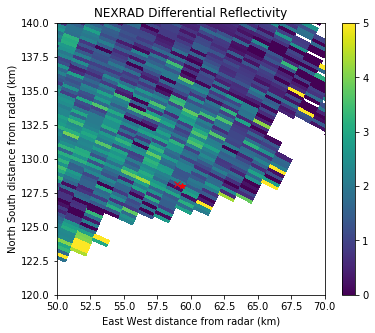

In [172]:
import pyart
radar_obj = radar_dict['radarsweeplist'][2]
xrad, yrad, zrad = radar_obj.get_gate_x_y_z(0)
distance = np.sqrt((PIPS_rad_loc[0] - xrad)**2. + (PIPS_rad_loc[1] - yrad)**2.)
theta_index, range_index = np.unravel_index(distance.argmin(), distance.shape)

print(theta_index, range_index)

display = pyart.graph.RadarDisplay(radar_obj)
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('ZDR', 0, title='NEXRAD Differential Reflectivity',
             vmin=0, vmax=5, colorbar_label='', ax=ax)
display.plot_range_ring(radar_obj.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-250, 250), ylim=(-250, 250))
display.set_limits(xlim=(50, 70), ylim=(120, 140), ax=ax)
ax.plot(PIPS_rad_loc[0]/1000., PIPS_rad_loc[1]/1000., 'r*')
ax.plot(xrad[theta_index, range_index]/1000., yrad[theta_index, range_index]/1000., 'rx')
#ax.contourf(xrad / 1000., yrad / 1000., distance)
#ax.text(PIPS_rad_loc[0] / 1000. - 5., PIPS_rad_loc[1] / 1000., 'PIPS1A', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [179]:
print(radar_fields_at_PIPS_da)

<xarray.DataArray (time: 20, PIPS: 1, fields: 6)>
array([[[17.5     , 22.5     ,  0.847222, 49.716255,  1.013519,  1.      ]],

       [[11.4     ,       nan,  0.7125  , 42.523438,  0.967667,       nan]],

       [[23.61111 , 22.5     ,  1.833333, 47.639866,  0.963889,  2.5     ]],

       [[15.8125  , 23.5     ,  1.320312, 37.110962,  0.9775  ,  1.75    ]],

       [[37.22222 , 25.875   ,  1.541667, 38.74653 ,  0.962407,  1.9375  ]],

       [[45.944443, 28.055555,  3.111111, 50.108074,  0.961667,  2.388889]],

       [[53.11111 ,  6.777778,  2.527778, 62.01812 ,  0.958333,  3.388889]],

       [[39.77778 , 12.888889,  1.659722, 58.217773,  0.986111,  4.777778]],

       [[46.27778 , 16.61111 ,  1.666667, 71.02886 ,  0.967963,  3.5     ]],

       [[50.38889 , 12.222222,  2.208333, 77.258026,  0.975741,  3.5     ]],

       [[40.77778 ,  7.222222,  2.569444, 80.82303 ,  0.945741,  3.611111]],

       [[18.583334, 12.666667,  2.1875  , 66.40592 ,  1.      ,  3.666667]],

       [[15.18

<xarray.DataArray (time: 20)>
array([17.5     , 11.4     , 23.61111 , 15.8125  , 37.22222 , 45.944443,
       53.11111 , 39.77778 , 46.27778 , 50.38889 , 40.77778 , 18.583334,
       15.1875  , 19.666666,       nan,       nan,       nan, 16.25    ,
             nan,       nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2016-03-31T22:00:34 ... 2016-03-31T23:35:53
    PIPS     <U6 'PIPS1A'
    fields   <U3 'REF'


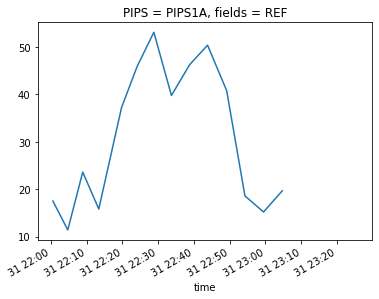

In [168]:
print(radar_fields_at_PIPS_da.sel(PIPS='PIPS1A', fields='REF'))
radar_fields_at_PIPS_da.sel(PIPS='PIPS1A', fields='REF').plot()

In [183]:
# Test dumping to netCDF file
ncfile_dir = './'
ncfile_name = '{}_{}_{}_fields_at_PIPS.nc'.format(radar_name, starttime, stoptime)
ncfile_path = os.path.join(ncfile_dir, ncfile_name)
radar.dump_radar_fields_at_PIPS_nc(ncfile_path, radar_fields_at_PIPS_da)

In [189]:
# Now test loading it back in
radar_fields_at_PIPS_ds = xr.open_dataset(ncfile_path)
print(radar_fields_at_PIPS_ds)

<xarray.Dataset>
Dimensions:               (PIPS: 1, fields: 6, time: 20)
Coordinates:
  * time                  (time) datetime64[ns] 2016-03-31T22:00:34 ... 2016-03-31T23:35:53
  * PIPS                  (PIPS) object 'PIPS1A'
  * fields                (fields) object 'REF' 'VEL' 'ZDR' 'PHI' 'RHO' 'SW'
    PIPS_x                (PIPS) float64 ...
    PIPS_y                (PIPS) float64 ...
Data variables:
    radar_fields_at_PIPS  (time, PIPS, fields) float32 ...


In [188]:
radar_fields_at_PIPS_da_2 = radar_fields_at_PIPS_ds['radar_fields_at_PIPS']
print(radar_fields_at_PIPS_da_2)

<xarray.DataArray 'radar_fields_at_PIPS' (time: 20, PIPS: 1, fields: 6)>
array([[[17.5     , 22.5     ,  0.847222, 49.716255,  1.013519,  1.      ]],

       [[11.4     ,       nan,  0.7125  , 42.523438,  0.967667,       nan]],

       [[23.61111 , 22.5     ,  1.833333, 47.639866,  0.963889,  2.5     ]],

       [[15.8125  , 23.5     ,  1.320312, 37.110962,  0.9775  ,  1.75    ]],

       [[37.22222 , 25.875   ,  1.541667, 38.74653 ,  0.962407,  1.9375  ]],

       [[45.944443, 28.055555,  3.111111, 50.108074,  0.961667,  2.388889]],

       [[53.11111 ,  6.777778,  2.527778, 62.01812 ,  0.958333,  3.388889]],

       [[39.77778 , 12.888889,  1.659722, 58.217773,  0.986111,  4.777778]],

       [[46.27778 , 16.61111 ,  1.666667, 71.02886 ,  0.967963,  3.5     ]],

       [[50.38889 , 12.222222,  2.208333, 77.258026,  0.975741,  3.5     ]],

       [[40.77778 ,  7.222222,  2.569444, 80.82303 ,  0.945741,  3.611111]],

       [[18.583334, 12.666667,  2.1875  , 66.40592 ,  1.      ,  3.66

In [186]:
print(radar_fields_at_PIPS_da)

<xarray.DataArray (time: 20, PIPS: 1, fields: 6)>
array([[[17.5     , 22.5     ,  0.847222, 49.716255,  1.013519,  1.      ]],

       [[11.4     ,       nan,  0.7125  , 42.523438,  0.967667,       nan]],

       [[23.61111 , 22.5     ,  1.833333, 47.639866,  0.963889,  2.5     ]],

       [[15.8125  , 23.5     ,  1.320312, 37.110962,  0.9775  ,  1.75    ]],

       [[37.22222 , 25.875   ,  1.541667, 38.74653 ,  0.962407,  1.9375  ]],

       [[45.944443, 28.055555,  3.111111, 50.108074,  0.961667,  2.388889]],

       [[53.11111 ,  6.777778,  2.527778, 62.01812 ,  0.958333,  3.388889]],

       [[39.77778 , 12.888889,  1.659722, 58.217773,  0.986111,  4.777778]],

       [[46.27778 , 16.61111 ,  1.666667, 71.02886 ,  0.967963,  3.5     ]],

       [[50.38889 , 12.222222,  2.208333, 77.258026,  0.975741,  3.5     ]],

       [[40.77778 ,  7.222222,  2.569444, 80.82303 ,  0.945741,  3.611111]],

       [[18.583334, 12.666667,  2.1875  , 66.40592 ,  1.      ,  3.666667]],

       [[15.18

In [194]:
print(radar_fields_at_PIPS_da_2['PIPS_x'])

<xarray.DataArray 'PIPS_x' (PIPS: 1)>
array([59330.327763])
Coordinates:
  * PIPS     (PIPS) object 'PIPS1A'
    PIPS_x   (PIPS) float64 5.933e+04
    PIPS_y   (PIPS) float64 1.28e+05


In [196]:
print(radar_fields_at_PIPS_da.fields)

<xarray.DataArray 'fields' (fields: 6)>
array(['REF', 'VEL', 'ZDR', 'PHI', 'RHO', 'SW'], dtype='<U3')
Coordinates:
  * fields   (fields) <U3 'REF' 'VEL' 'ZDR' 'PHI' 'RHO' 'SW'


In [197]:
'RHO' in radar_fields_at_PIPS_da.fields

True

In [198]:
radar_fields_at_PIPS_da.sel(PIPS='PIPS1A', fields='RHO').size

20

In [202]:
pd.to_datetime(radar_fields_at_PIPS_da['time'].values).to_pydatetime()

array([datetime.datetime(2016, 3, 31, 22, 0, 34),
       datetime.datetime(2016, 3, 31, 22, 4, 44),
       datetime.datetime(2016, 3, 31, 22, 8, 55),
       datetime.datetime(2016, 3, 31, 22, 13, 24),
       datetime.datetime(2016, 3, 31, 22, 19, 46),
       datetime.datetime(2016, 3, 31, 22, 24, 9),
       datetime.datetime(2016, 3, 31, 22, 28, 48),
       datetime.datetime(2016, 3, 31, 22, 33, 43),
       datetime.datetime(2016, 3, 31, 22, 38, 49),
       datetime.datetime(2016, 3, 31, 22, 43, 49),
       datetime.datetime(2016, 3, 31, 22, 49, 10),
       datetime.datetime(2016, 3, 31, 22, 54, 16),
       datetime.datetime(2016, 3, 31, 22, 59, 28),
       datetime.datetime(2016, 3, 31, 23, 4, 43),
       datetime.datetime(2016, 3, 31, 23, 10, 9),
       datetime.datetime(2016, 3, 31, 23, 15, 25),
       datetime.datetime(2016, 3, 31, 23, 20, 35),
       datetime.datetime(2016, 3, 31, 23, 25, 40),
       datetime.datetime(2016, 3, 31, 23, 30, 44),
       datetime.datetime(2016, 3, 31,